In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import asc, col, count, desc, explode, udf, pandas_udf
from pyspark.sql.types import ArrayType, BooleanType, DoubleType, IntegerType, StringType
import matplotlib.pyplot as plt
from pyspark_dist_explore import hist

In [2]:
MASTER: str = "local"
DATA_PATH: str = "/media/maya/Samsung_T5/quasar"
PYTHON_PATH: str = "/home/maya/miniconda3/envs/quasarenv/bin/python"

In [3]:
import sys, os
os.environ['PYSPARK_PYTHON'] = PYTHON_PATH

In [4]:
spark: SparkSession = SparkSession.builder.appName("Spectra_Data_Cleaning") \
    .master(MASTER).getOrCreate()

In [5]:
df: DataFrame = spark.read.parquet(f'{DATA_PATH}/spectra.parquet', mergeSchema=True)

In [9]:
df.dtypes

[('_corrupt_record', 'string'),
 ('_id', 'struct<$oid:string>'),
 ('continuum', 'array<string>'),
 ('dec', 'double'),
 ('fiber', 'bigint'),
 ('mjd', 'bigint'),
 ('name', 'string'),
 ('plate', 'bigint'),
 ('ra', 'double'),
 ('size', 'bigint'),
 ('spectraSetOID', 'struct<$oid:string>'),
 ('spectrum', 'array<string>'),
 ('subtype', 'string'),
 ('type', 'string'),
 ('z', 'double'),
 ('zerr', 'double')]

## Usunięcie wadliwych danych

In [10]:
df.count()

526323

In [6]:
df = df.filter(df['_corrupt_record'].isNull())

In [7]:
df.count()

526305

## Deklinacja i rektascensja

**Prawidłowy zakres deklinacji**: [-90.0, +90.0] \
**Prawidłowy zakres rektascensji**: [0.0, 360.0]

In [16]:
df.select('dec').describe().show()

+-------+------------------+
|summary|               dec|
+-------+------------------+
|  count|            526305|
|   mean| 27.12275825183804|
| stddev|19.663092374128407|
|    min|        -17.520444|
|    max|         84.431417|
+-------+------------------+



In [17]:
df.select('ra').describe().show()

+-------+--------------------+
|summary|                  ra|
+-------+--------------------+
|  count|              526305|
|   mean|    166.392792852097|
| stddev|   92.35721606872647|
|    min|0.001898274356335...|
|    max|   359.9999541295649|
+-------+--------------------+



## Przesunięcie ku czerwieni

In [18]:
df.select(['z', 'zerr']).describe().show()

+-------+--------------------+-------------------+
|summary|                   z|               zerr|
+-------+--------------------+-------------------+
|  count|              526305|             526305|
|   mean|  1.8437681119902865|0.03196534306632566|
| stddev|   0.808477251570882|  6.016786166216214|
|    min|-0.00968325324356556|               -6.0|
|    max|   7.016780853271484|    3614.9326171875|
+-------+--------------------+-------------------+



Text(0.5, 1.0, 'Błąd pomiarowy przesunięcia ku czerwieni')

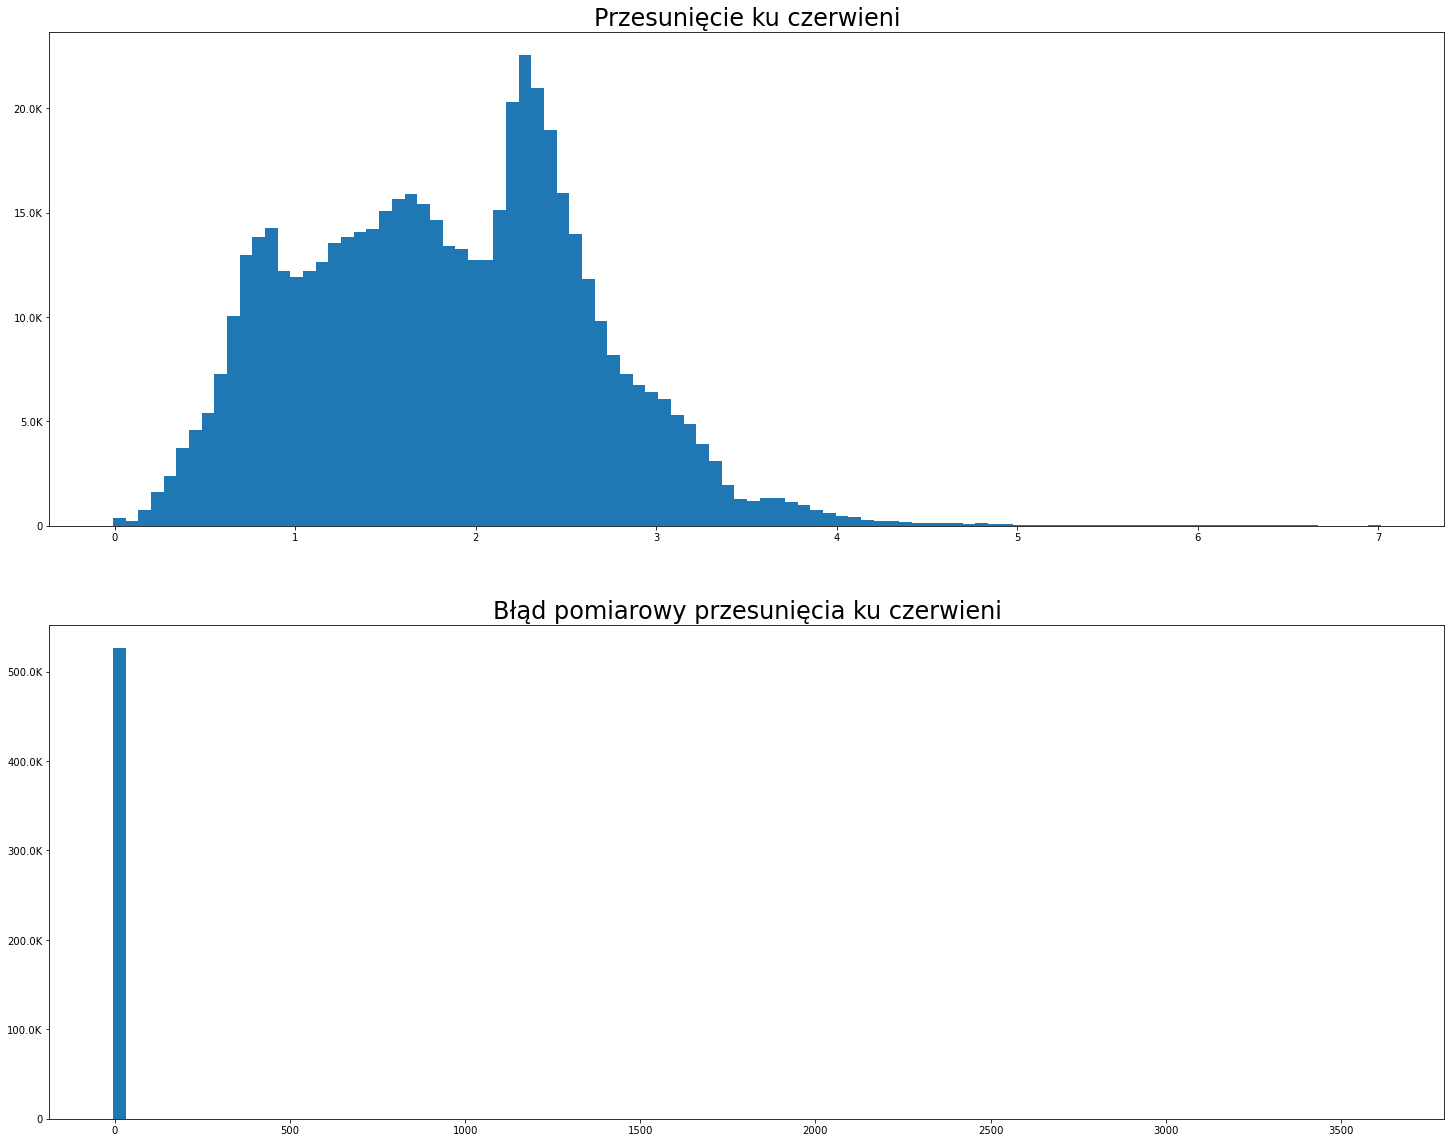

In [21]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(25, 20))

hist(ax[0], df.select('z'), bins=100)
ax[0].set_title('Przesunięcie ku czerwieni', fontdict={'fontsize': 24})

hist(ax[1], df.select('zerr'), bins=100)
ax[1].set_title('Błąd pomiarowy przesunięcia ku czerwieni', fontdict={'fontsize': 24})

In [6]:
df.approxQuantile('zerr', [0.997], 0)[0]

0.27208131551742554

In [8]:
zerr_99_quantile: DoubleType() = df.approxQuantile('zerr', [0.996], 0)[0]

In [13]:
zerr_99_quantile

0.006447033025324345

Odrzucone rekordy dane, których błąd pomiarowy jest większy niż pozostałych 99,6% rekordów.

In [8]:
df = df.filter(df['zerr']<=zerr_99_quantile)

Text(0.5, 1.0, 'Błąd pomiarowy przesunięcia ku czerwieni')

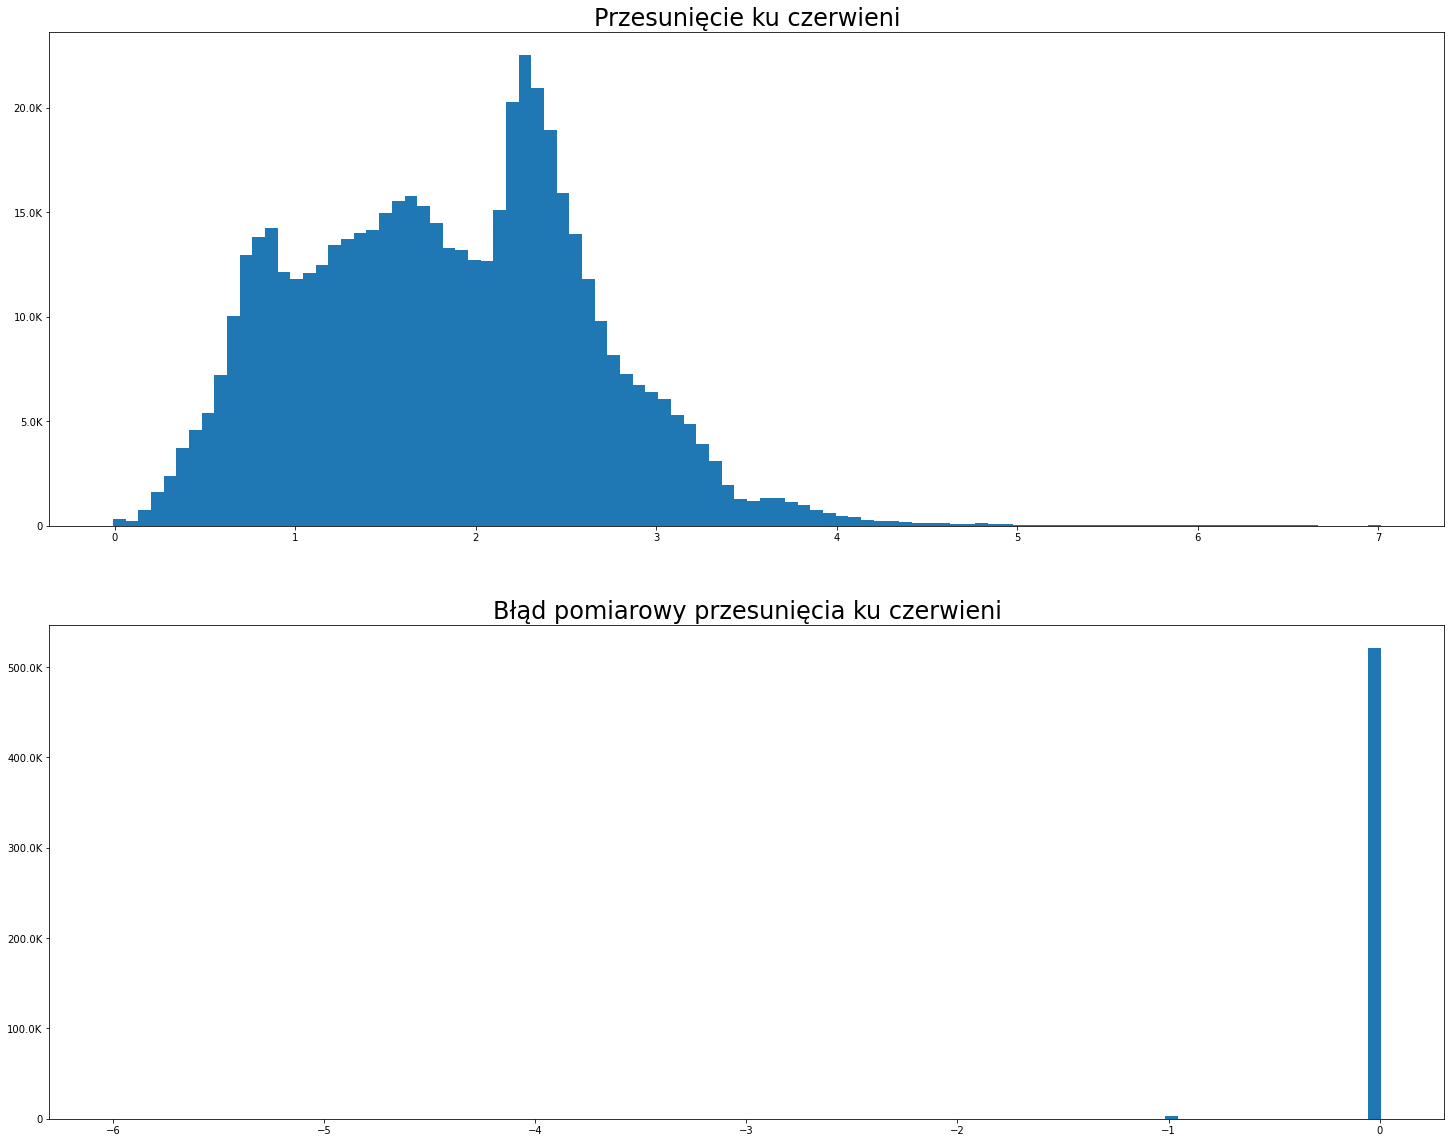

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 20))

hist(ax[0], df.select('z'), bins=100)
ax[0].set_title('Przesunięcie ku czerwieni', fontdict={'fontsize': 24})

hist(ax[1], df.select('zerr'), bins=100)
ax[1].set_title('Błąd pomiarowy przesunięcia ku czerwieni', fontdict={'fontsize': 24})

Prawidłowa wartość błędu pomiarowego powinna być większa od 0. (Nie może tez wynosić równo 0- idealnie dokładny pomiar jest niemożliwy)

In [9]:
df = df.filter(df['zerr']>0.0)

Text(0.5, 1.0, 'Błąd pomiarowy przesunięcia ku czerwieni')

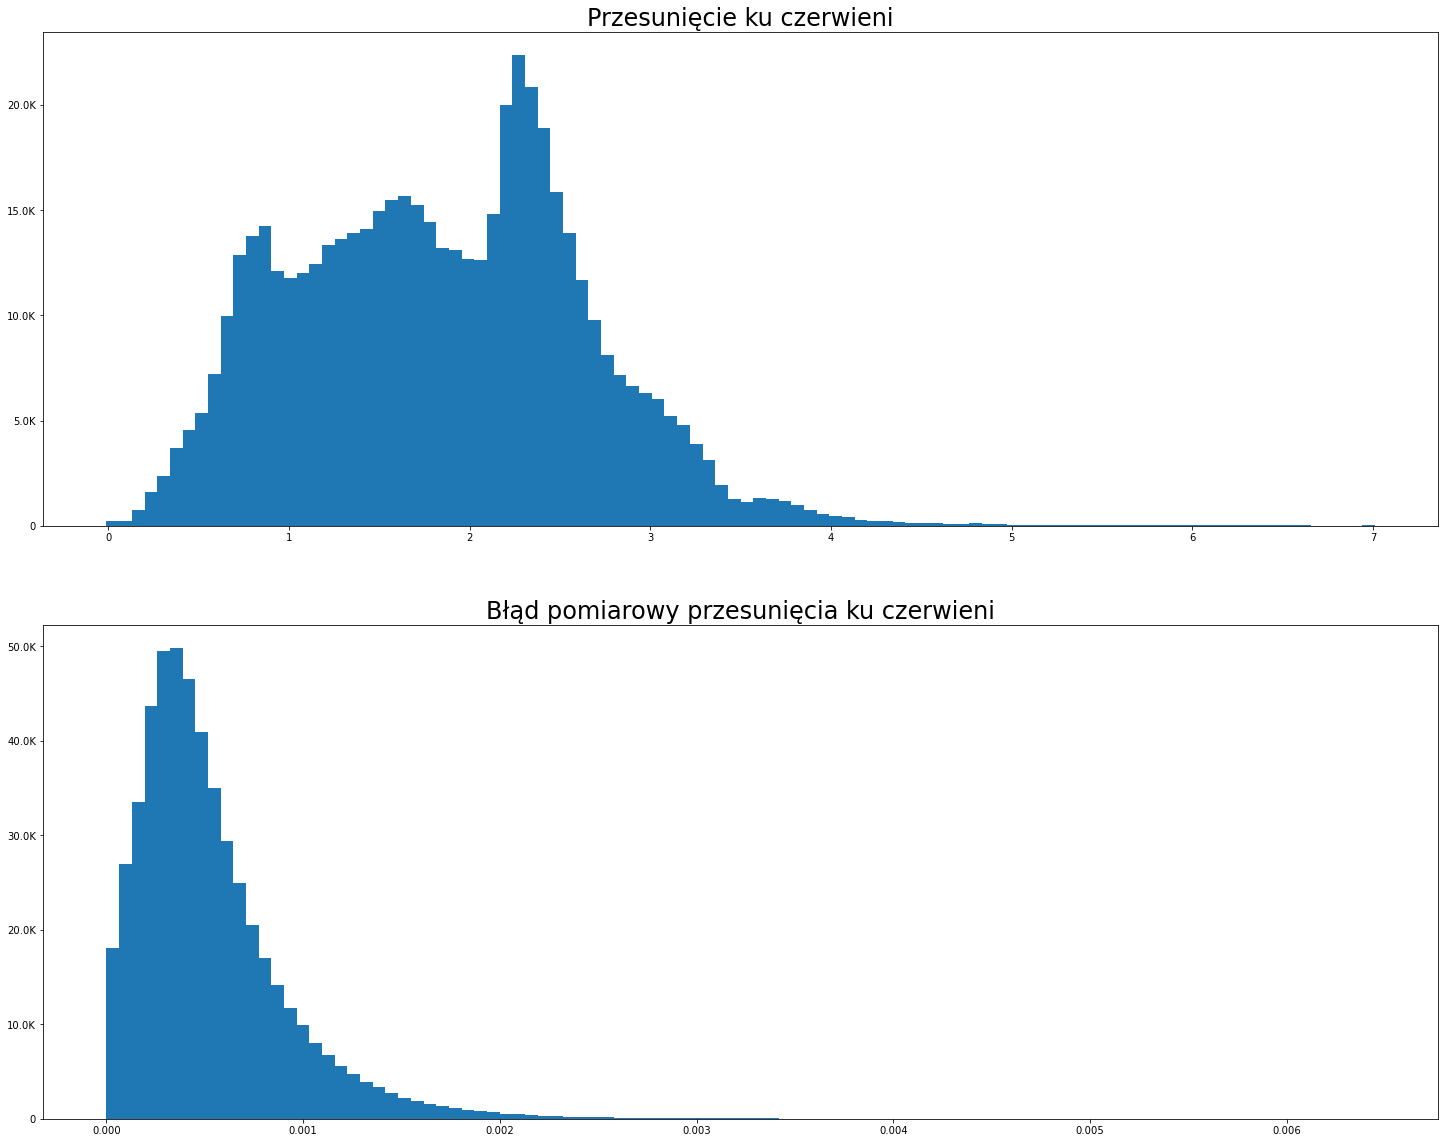

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 20))

hist(ax[0], df.select('z'), bins=100)
ax[0].set_title('Przesunięcie ku czerwieni', fontdict={'fontsize': 24})

hist(ax[1], df.select('zerr'), bins=100)
ax[1].set_title('Błąd pomiarowy przesunięcia ku czerwieni', fontdict={'fontsize': 24})

In [10]:
ZERR_OUTLIER_VALUE: float = 0.001711744283889273

In [11]:
df = df.filter(df['zerr']<=ZERR_OUTLIER_VALUE)

## Typ

In [53]:
df.select(['type']).distinct().show()

+------+
|  type|
+------+
|GALAXY|
|QSO   |
|   QSO|
|STAR  |
|  STAR|
+------+



In [12]:
@udf(StringType())
def normalize_type_name(x: StringType()) -> StringType():
    return x.strip().replace(' ', '').upper()

In [13]:
df = df.withColumn('type', normalize_type_name(col('type')))

In [ ]:
df.select(['type']).distinct().show()

## Subtype

In [60]:
df.select(['subtype']).distinct().show()

+--------------------+
|             subtype|
+--------------------+
|      F8V (G_243-63)|
|L5.5             ...|
|      M5III (221615)|
|      F3/F5V (30743)|
|        A5II (34578)|
|        A2II (39866)|
|         M1 (204445)|
|      M8IIIe (84748)|
|STARBURST        ...|
|        O8e (188001)|
|M9               ...|
|                 AGN|
|       G0 (G_101-29)|
|   M4.5:III (123657)|
|STARFORMING      ...|
|L9               ...|
|              Carbon|
|    G5/G6IVw (26297)|
|       A0IVn (25642)|
| B0.5Ibe... (187459)|
+--------------------+
only showing top 20 rows



In [14]:
len(df.select(['subtype']).distinct().collect())

88

In [15]:
df = df.withColumn('subtype', normalize_type_name(col('subtype')))

In [65]:
df.select(['subtype']).distinct().show()

+------------------+
|           subtype|
+------------------+
|B0.5Ibe...(187459)|
|      K1III(18322)|
|       F0IV(81937)|
|                M4|
|     K2III(115136)|
|       A6IV(28527)|
|               AGN|
|      A4(G_165-39)|
|        K0V(10780)|
|     M2Iab:(36389)|
|            Carbon|
|        G4V(32923)|
|        F2V(33256)|
|      G0(G_101-29)|
|     K1IVa(142091)|
|STARBURSTBROADLINE|
|                CV|
|        F0V(90277)|
|     K5III(120933)|
|    F6Iab:(187929)|
+------------------+
only showing top 20 rows



In [24]:
len(df.select(['subtype']).distinct().collect())

81

## Zmodyfikowana data juliańska

In [68]:
df.select('mjd').describe().show()

+-------+------------------+
|summary|               mjd|
+-------+------------------+
|  count|            520957|
|   mean|55949.133335380844|
| stddev|1433.5061829095735|
|    min|             51608|
|    max|             57520|
+-------+------------------+



51608 -> 03-05-2000 \
57520 -> 05-12-2016

## Fiber

In [64]:
df.select('fiber').describe().show()

+-------+-----------------+
|summary|            fiber|
+-------+-----------------+
|  count|           523673|
|   mean|472.6815760980612|
| stddev|282.6424996456361|
|    min|                1|
|    max|             1000|
+-------+-----------------+



## Plate

In [65]:
df.select('plate').describe().show()

+-------+-----------------+
|summary|            plate|
+-------+-----------------+
|  count|           523673|
|   mean|5700.317873940417|
| stddev|2298.768491884857|
|    min|              266|
|    max|            10000|
+-------+-----------------+



## Continuum, Spectrum

In [15]:
df: DataFrame = df.withColumn("continuum", df["continuum"].cast(ArrayType(DoubleType()))) \
    .withColumn("spectrum", df["spectrum"].cast(ArrayType(DoubleType())))

In [5]:
df = spark.read.parquet(f'{DATA_PATH}/cleaned-spectra.parquet')

In [6]:
@udf(IntegerType())
def countNonNones(x: ArrayType(DoubleType())) -> IntegerType():
    if x:
        return len([y for y in x if y!=None])
    return 0

In [7]:
df = df.withColumn('spectrum_non_nones', countNonNones(col('spectrum'))) \
       .withColumn('continuum_non_nones', countNonNones(col('continuum'))) \
       .dropna() \
       .cache()

Text(0.5, 1.0, 'Wartości w wektorze Spectrum')

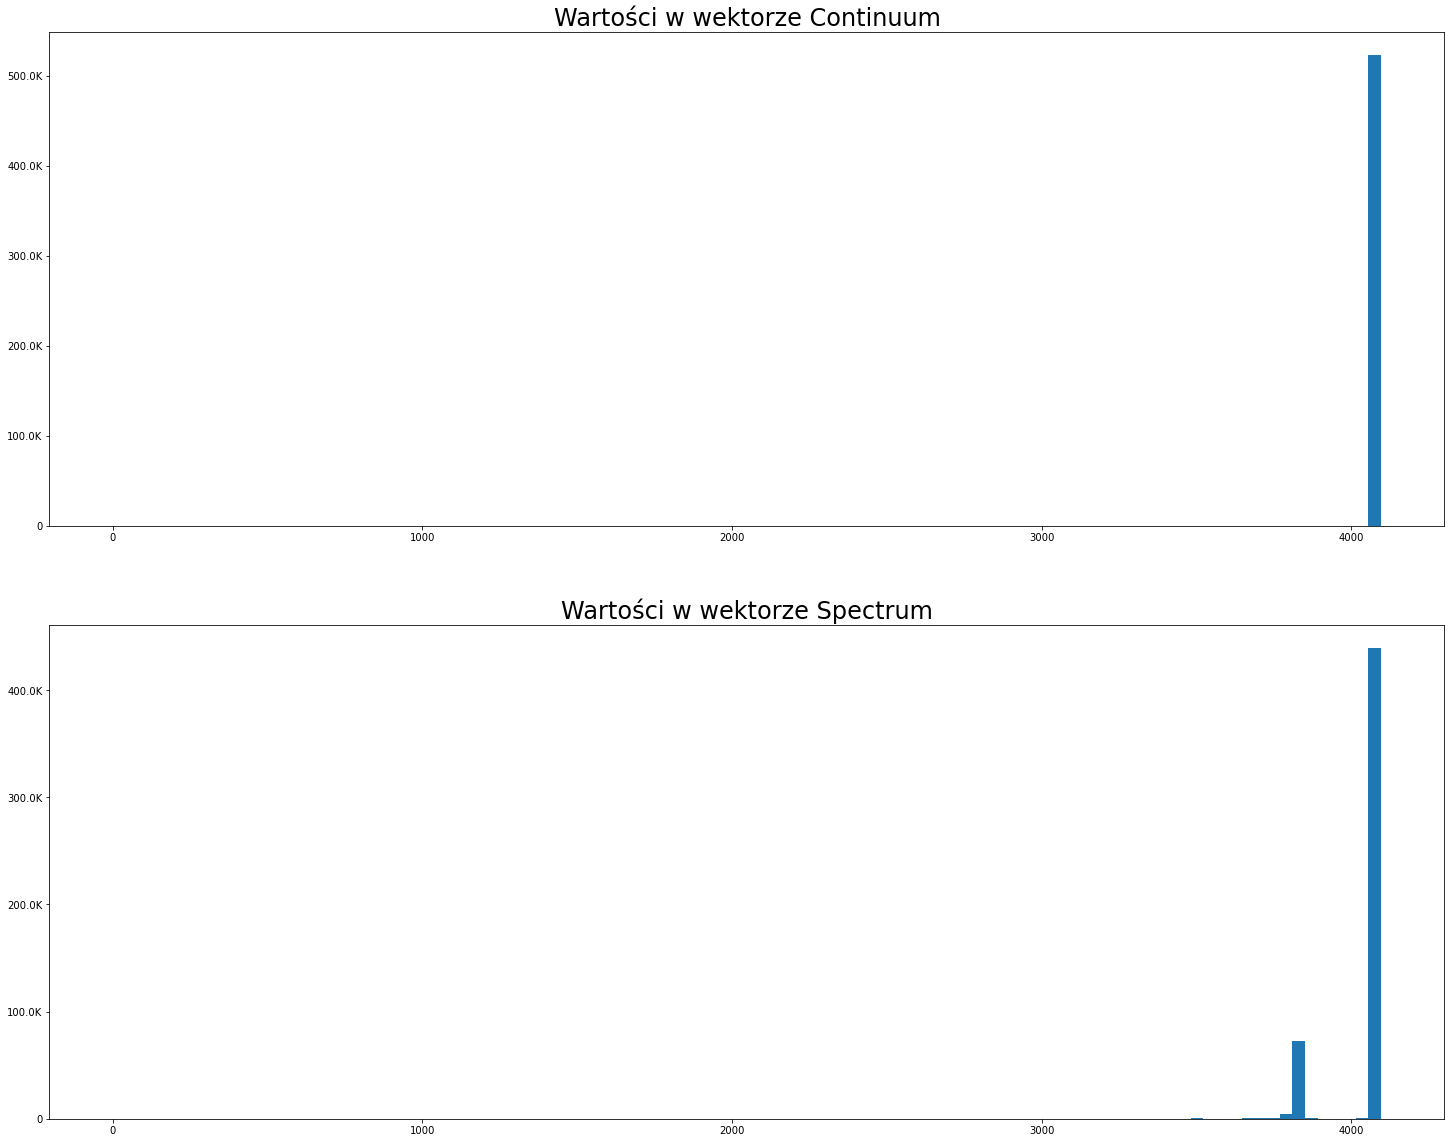

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(25, 20))

hist(ax[0], continuumCounts.select('continuum_non_nones'), bins=100)
ax[0].set_title('Wartości w wektorze Continuum', fontdict={'fontsize': 24})

hist(ax[1], spectrumCounts.select('spectrum_non_nones'), bins=100)
ax[1].set_title('Wartości w wektorze Spectrum', fontdict={'fontsize': 24})

In [8]:
spectrum_quantile: IntegerType() = 3492

In [9]:
counts_df = df.filter((df.spectrum_non_nones >= spectrum_quantile)\
                     & (df.continuum_non_nones >= spectrum_quantile)).select('id')

In [13]:
counts_df.show(truncate=False)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38437)
Traceback (most recent call last):
  File "/home/maya/miniconda3/envs/quasarenv/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/maya/miniconda3/envs/quasarenv/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:38437)

In [12]:
counts_df.write.parquet(f'{DATA_PATH}/cleaned_spectra_ids.parquet')

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 46698)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/maya/miniconda3/envs/quasarenv/lib/python3.8/site-packages/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/maya/miniconda3/envs/quasarenv/lib/python3.8/site-packages/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/home/maya/miniconda3/envs/quasarenv/lib/python3.8/site-packages/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
  File "/home/maya/miniconda3/envs/quasaren

Py4JError: An error occurred while calling o83.parquet

In [19]:
counts_df.show()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:39469)
Traceback (most recent call last):
  File "/home/maya/miniconda3/envs/quasarenv/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/maya/miniconda3/envs/quasarenv/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:39469)

## Cleaned data

Attributes used in further modelling:

    - continuum
    - type
    - subtype
    - spectrum
    - z
    
Attributes used in concatenation with other tables:

    - id
    - spectra set id

In [35]:
df.dtypes

[('id', 'string'),
 ('spectra_set_id', 'string'),
 ('continuum', 'array<double>'),
 ('type', 'string'),
 ('subtype', 'string'),
 ('spectrum', 'array<double>'),
 ('z', 'double'),
 ('spectrum_non_nones', 'int'),
 ('continuum_non_nones', 'int')]

In [18]:
cleaned_data = df.select(col('_id.$oid').alias('id'),
                                  col('spectraSetOID.$oid').alias('spectra_set_id'),
                                  'continuum', 'type', 'subtype', 'spectrum', 'z')

In [19]:
cleaned_data.count()

512657

In [21]:
cleaned_data.write.parquet(f'{DATA_PATH}/cleaned-spectra.parquet')

In [22]:
cleaned_data.count()

512657